<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/GroupZ_Model_Compilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Import All Dependencies & Libraries

In [52]:
%pip install scikit-optimize

In [53]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from scipy.stats import mode
from matplotlib import colormaps
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, SimpleRNN, Dense,
    Conv1D, GlobalMaxPooling1D, Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


# Data Loading

In [54]:
# Importing the dataset from GitHub
github_csv_url = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
raw_dataset = pd.read_csv(github_csv_url)

# Data Pre-pocessing

In [55]:
''' Dataset for Deep Learning '''
# Copy the raw dataset with only 'url' and 'status' columns
DL_dataset = raw_dataset[['url', 'status']].copy()
DL_dataset['url'] = DL_dataset['url'].str.lower()

# Encode status column
label_encoder = LabelEncoder()
DL_dataset['status'] = label_encoder.fit_transform(DL_dataset['status'])

# Tokenize URLs for RNN
urls = DL_dataset['url'].astype(str).values
labels = DL_dataset['status'].values

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_len = 200
X_padded = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1


''' Dataset for Machine Learning '''
# Copy the raw dataset
ML_dataset = raw_dataset.copy()

# Drop the URL columns (ML only need numeric vectors data)
if 'url' in ML_dataset.columns:
    ML_dataset = ML_dataset.drop(columns=['url'])

# Model Used





*   **Dyaniel** -> Recurrent Nueral Network (RNN) + Cluster Labeling K-Means (CL K-Means)
*   **Ho Feng Sheng** -> Convolutional Nueral Network (CNN) + Support Vector Machine (SVM)
*   **Lee Zhen Yong** -> Random Forest
*   **Lee Guo Xi** -> Long Short-Term Memory (LSTM)

# Model Training

## Dyaniel Model Training (RNN + CL K-Means)

### 1. RNN Deep Learning Model

In [56]:
# Set start time for recording the model training time
dy_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# Train/test split
dy_X_train, dy_X_test, dy_y_train, dy_y_test = train_test_split(
    X_padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build RNN model
input_layer = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=32)(input_layer)
rnn_output = SimpleRNN(64, return_sequences=False, name="rnn_features")(embedding)
output = Dense(1, activation='sigmoid')(rnn_output)

RNN_model = Model(inputs=input_layer, outputs=output)
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN with custom settings
RNN_model.fit(
    dy_X_train,
    dy_y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.5904 - loss: 0.6603 - val_accuracy: 0.8114 - val_loss: 0.4326
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.8068 - loss: 0.4436 - val_accuracy: 0.8338 - val_loss: 0.3917
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.8328 - loss: 0.3863 - val_accuracy: 0.8278 - val_loss: 0.4020
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8385 - loss: 0.3817 - val_accuracy: 0.8436 - val_loss: 0.3833
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8666 - loss: 0.3228 - val_accuracy: 0.8059 - val_loss: 0.4295
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8590 - loss: 0.3374 - val_accuracy: 0.7879 - val_loss: 0.4451
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8662 - loss: 0.3179 - val_accuracy: 0.6555 - val_loss: 0.6336
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8292 - loss: 0.3915 -

### 2. Extract RNN Features & Merge with ML_Dataset

In [57]:
# Create a new model that outputs the RNN layer
feature_extractor = Model(
    inputs=RNN_model.input,
    outputs=RNN_model.get_layer("rnn_features").output  # 'rnn_features' is the layer name
)

try:
    # Apply it on the full padded URL input
    rnn_features = feature_extractor.predict(X_padded)

    # Convert to DataFrame
    rnn_feature_df = pd.DataFrame(
        rnn_features,
        columns=[f"rnn_feat_{i}" for i in range(rnn_features.shape[1])]
    )
except Exception as e:
    print(f"❌ An error occurred during RNN feature extraction: {e}")
finally:
    print("✅ RNN feature extraction process done.")


try:
  # Drop "status" column and reset index
  ml_only = ML_dataset.drop(columns=['status']).reset_index(drop=True)

  # Standardize ML features
  scaler = StandardScaler()
  ml_scaled = scaler.fit_transform(ml_only)
  ml_scaled_df = pd.DataFrame(ml_scaled, columns=ml_only.columns)

  # Combine with RNN features
  combined_features = pd.concat([ml_scaled_df, rnn_feature_df], axis=1)

  # Reattach "status" column
  ML_combined_dataset = combined_features.copy()
  ML_combined_dataset['status'] = ML_dataset['status'].reset_index(drop=True)

except Exception as e:
    print(f"❌ An error occurred during ML dataset merging: {e}")
finally:
    print("✅ ML dataset merging done.")
    print("Final merged and scaled dataset shape:", ML_dataset.shape)

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
✅ RNN feature extraction process done.
✅ ML dataset merging done.
Final merged and scaled dataset shape: (11430, 88)


### 3. CL_K-Means Machine Learning

In [58]:
X = ML_combined_dataset.drop(columns=['status'])
y = ML_combined_dataset['status']

# Find the Best k using BO-TPE (Bayesian Optimization)
search_space = {'n_clusters': Integer(2, 10)}
opt_kmeans = BayesSearchCV(KMeans(random_state=42), search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt_kmeans.fit(X, y)
best_k = opt_kmeans.best_params_['n_clusters']
print(f"✅ Best k found by BO-TPE: {best_k}")

# Train CL-KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map clusters to true labels using majority voting
mapped_labels = np.zeros_like(clusters)
for i in range(best_k):
    mask = (clusters == i)
    mapped_labels[mask] = mode(y[mask])[0]

# Train Random Forest for Bias Correction
dy2_X_train, dy2_X_test, dy2_y_train, dy2_y_test = train_test_split(X, mapped_labels, test_size=0.2, stratify=y, random_state=42)
bias_corrector = RandomForestClassifier(random_state=42)
bias_corrector.fit(dy2_X_train, dy2_y_train)

# Get the model training time
dy_training_time = time.time() - dy_train_start_time
dy_training_time = round(dy_training_time / 60, 4)

✅ Best k found by BO-TPE: 2


## Ho Feng Sheng Model Training (CNN + SVM)

### 1. Train CNN to Learn from URL

In [59]:
# Set start time for recording the model training time
js_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# CNN architecture
input_layer = Input(shape=(200,))
embedding = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
conv = Conv1D(filters=256, kernel_size=5, activation='relu')(embedding)
drop = Dropout(0.3)(conv)
pool = GlobalMaxPooling1D(name="cnn_features")(drop)
output_layer = Dense(1, activation='sigmoid')(pool)

# Compile model
CNN_model = Model(inputs=input_layer, outputs=output_layer)
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split for DL training only
js_X_train_dl, js_X_test_dl, js_y_train_dl, js_y_test_dl = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Train CNN model
CNN_model.fit(js_X_train_dl, js_y_train_dl, epochs=5, batch_size=128, validation_split=0.1, verbose=1)



Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 576ms/step - accuracy: 0.7181 - loss: 0.5694 - val_accuracy: 0.8153 - val_loss: 0.4043
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.8464 - loss: 0.3560 - val_accuracy: 0.8798 - val_loss: 0.3295
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.8819 - loss: 0.2867 - val_accuracy: 0.8874 - val_loss: 0.2936
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.9059 - loss: 0.2362 - val_accuracy: 0.9016 - val_loss: 0.2559
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 585ms/step - accuracy: 0.9203 - loss: 0.2061 - val_accuracy: 0.9158 - val_loss: 0.2378


### 2. Extract CNN Features & Merge with ML Features

In [60]:
# Create a feature extractor model that outputs from 'cnn_features' layer
feature_extractor = Model(inputs=CNN_model.input,
                          outputs=CNN_model.get_layer("cnn_features").output)

# Apply on all padded URL sequences to extract CNN features
cnn_features = feature_extractor.predict(X_padded)

# Standardize ML numerical features
ml_features = raw_dataset.drop(columns=['url', 'status'])
scaler = StandardScaler()
ml_scaled = scaler.fit_transform(ml_features)

# Combine CNN features with numeric ML features
X_combined = np.hstack([cnn_features, ml_scaled])

358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


### 3. Train Final SVM Classifier

In [61]:
js2_X_train, js2_X_test, js2_y_train, js2_y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

svm_model = LinearSVC(
    loss="squared_hinge", penalty='l2', dual=True, max_iter=100000,
    tol=1e-3, class_weight='balanced', C=1.0, random_state=42
)

svm_model.fit(js2_X_train, js2_y_train)

# Get the model training time
js_training_time = time.time() - js_train_start_time
js_training_time = round(js_training_time / 60, 4)

# Model Evaluation Metrics

## Get Model Metrics

In [62]:
''' Get Dyaniel Model Metrics '''
# Calculate Prediction Time
dy_pred_start_time = time.time()
dy_corrected_preds = bias_corrector.predict(dy2_X_test)
dy_prediction_time = time.time() - dy_pred_start_time
dy_prediction_time = round(dy_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
dy_accuracy = accuracy_score(dy2_y_test, dy_corrected_preds)
precision = precision_score(dy2_y_test, dy_corrected_preds, average='weighted')
recall = recall_score(dy2_y_test, dy_corrected_preds, average='weighted')
dy_f1 = f1_score(dy2_y_test, dy_corrected_preds, average='weighted')

''' Get Joseph Model Metrics '''
# Calculate Prediction Time
js_predict_start_time = time.time()
js_corrected_preds = svm_model.predict(js2_X_test)
js_prediction_time = time.time() - js_predict_start_time
js_prediction_time = round(js_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
js_y_scores = svm_model.decision_function(js2_X_test)
js_accuracy = accuracy_score(js2_y_test, js_corrected_preds)
js_precision = precision_score(js2_y_test, js_corrected_preds)
js_recall = recall_score(js2_y_test, js_corrected_preds)
js_f1 = f1_score(js2_y_test, js_corrected_preds)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)

## Confusion Matrix

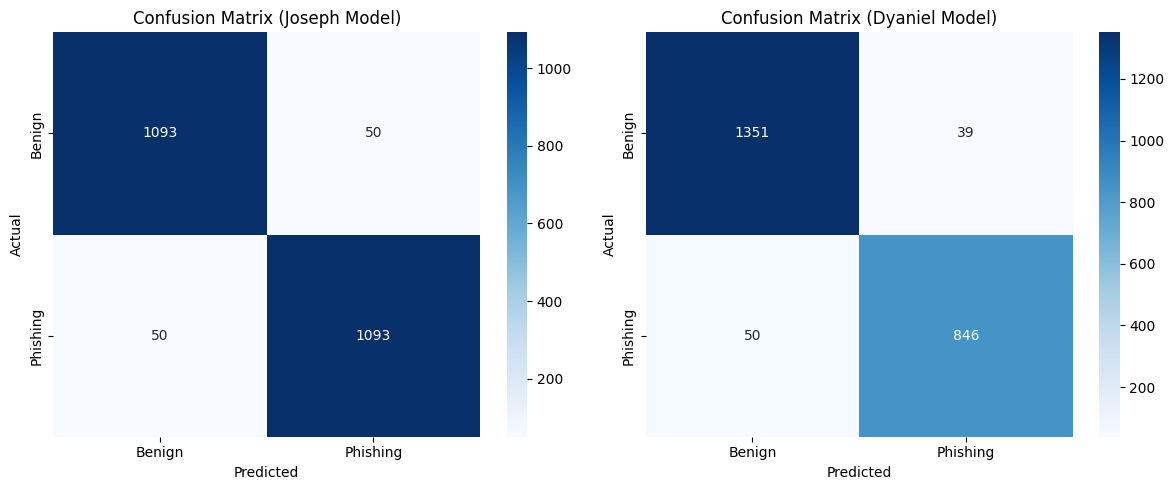

In [63]:
# Combined Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Joseph Model Confusion Matrix
cm_js = confusion_matrix(js2_y_test, js_corrected_preds)
sns.heatmap(cm_js, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Joseph Model)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Dyaniel Model Confusion Matrix
cm_dy = confusion_matrix(dy2_y_test, dy_corrected_preds)
sns.heatmap(cm_dy, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Dyaniel Model)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## ROC-AUC Curve

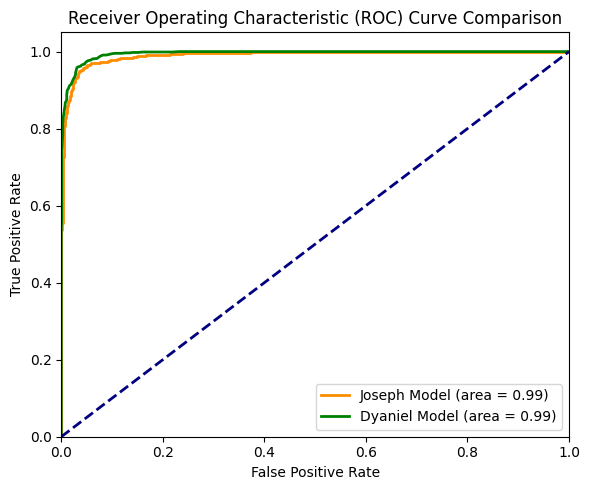

In [64]:
# Combined ROC Curve
plt.figure(figsize=(6, 5))

# Joseph Model ROC Curve
js_y_scores = svm_model.decision_function(js2_X_test)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)
fpr_js, tpr_js, thresholds_js = roc_curve(js2_y_test, js_y_scores)
plt.plot(fpr_js, tpr_js, color='darkorange', lw=2, label=f'Joseph Model (area = {js_roc_auc:.2f})')

# Dyaniel Model ROC Curve
if hasattr(bias_corrector, "predict_proba"):
    dy_y_scores = bias_corrector.predict_proba(dy2_X_test)[:, 1]
    dy_roc_auc = roc_auc_score(dy2_y_test, dy_y_scores)
    fpr_dy, tpr_dy, thresholds_dy = roc_curve(dy2_y_test, dy_y_scores)
    plt.plot(fpr_dy, tpr_dy, color='green', lw=2, label=f'Dyaniel Model (area = {dy_roc_auc:.2f})')
else:
    print("ROC curve for Dyaniel Model cannot be plotted as the model does not have 'predict_proba'.")


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Metrics Comparison

In [65]:
# Create a dictionary to store the metrics
metrics_data = {
    'Model': ['Dyaniel Model', 'Joseph Model'],
    'Accuracy': [dy_accuracy, js_accuracy],
    'Precision': [precision, js_precision],
    'Recall': [recall, js_recall],
    'F1-Score': [dy_f1, js_f1],
    'Training Time (min)': [dy_training_time, js_training_time],
    'Prediction Time (ms)': [dy_prediction_time, js_prediction_time]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (min),Prediction Time (ms)
0,Dyaniel Model,0.961067,0.961027,0.961067,0.961024,3.9225,43.7407
1,Joseph Model,0.956255,0.956255,0.956255,0.956255,4.2078,1.8628
